In [47]:
import numpy as np
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt

**(1)** Сигнал консинуса и его спектр:

In [48]:
def cosinus(A, t, T): # Пусть A будет не константой (для разнообразия)
    w = (2 * np.pi) / T

    return A * np.cos(w * t)

In [49]:
cos_time = np.arange(0, 0.1, 0.0001)

cos_50hz = [cosinus(4, a, 1/50) for a in cos_time]
cos_150hz = [cosinus(2, a, 1/150) for a in cos_time]
cos_450hz = [cosinus(6, a, 1/450) for a in cos_time]

cos_total1 = np.add(np.add(cos_50hz, cos_150hz), cos_450hz)

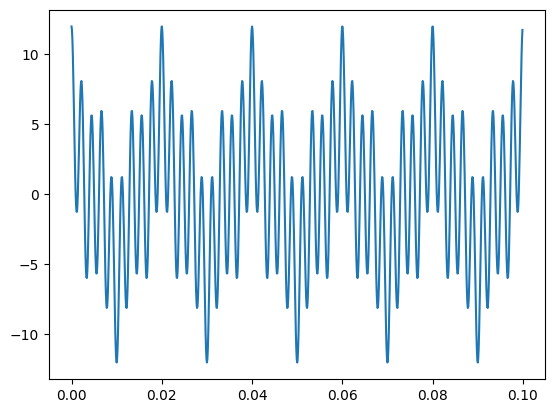

In [50]:
plt.plot(cos_time, cos_total1)
plt.show()

Теперь перейдём к реализации вот этих вот фильтров:

![](https://habrastorage.org/r/w1560/webt/9l/cb/ql/9lcbqlilgo7p0cfomhwtu8qezxe.png)



**(2)** Фильтр <!-- Бутерброда --> Баттерворта нижних частот (ФНЧ) 2-го порядка (стр. 67-69):

- `w` — частота
- `w_c` — частота среза фильтра ("граничиная частота")
- `omega` — безразмерная нормированная частота ($\omega = \frac{W}{W_c}$)

In [51]:
def butterwort_lofreq(w, w_c):
    return ((w_c**2) / (-w**2 + (1j * np.sqrt(2) * w_c * w) + w_c**2))

При применении ФНЧ происходит сильное подавление высоких частот (150 и 450 Гц), при этом частота 50 Гц подавляется гораздо слабее:

In [52]:
cos_frequencies = np.fft.fftfreq(len(cos_time), 0.0001)
# cos_total1_fft = np.fft.fft(cos_total1)

# cos_total1_LFfilter = butterwort_lofreq(cos_frequencies, 70)
# cos_total1_LFfilter = np.fft.ifft(cos_total1_LFfilter)

# cos_total1_LFfiltered_fft = np.multiply(cos_total1_fft, cos_total1_LFfilter)
# cos_total1_LFfiltered = np.fft.ifft(cos_total1_LFfiltered_fft)

In [53]:
def compare_original_filtered(time, freq, original, filter_fun, filter_freq, ffts_plotOX_scale=1):
    # 1. FFT оригинального сигнала
    original_fft = np.fft.fft(original)

    # 2. Вычисляем временнОе представление фильтра
    filter = filter_fun(freq, filter_freq)
    filter_ifft = np.fft.ifft(filter)

    # 3. Перемножаем значения фильтра и оригинала, как бы применяя "маску"
    filtered_fft = np.multiply(original_fft, filter)
    filtered = np.fft.ifft(filtered_fft)


    # plt.figure(figsize=(12, 4))
    plt.figure(figsize=(16, 8))
    plt.suptitle('Функция до (СЛЕВА) и после (ЦЕНТР) фильтрации, а также визуализация фильтра (СПРАВА), во временном (СВЕРХУ) и частотном (СНИЗУ) представлениях')

    plt.subplot(2, 3, 1)
    plt.plot(time, original)

    plt.subplot(2, 3, 2)
    plt.plot(time, (filtered / filtered.max() * original.max()))

    plt.subplot(2, 3, 4)
    plt.plot(
        freq[0:len(freq)//(2*ffts_plotOX_scale)],
        original_fft[0:len(freq)//(2*ffts_plotOX_scale)]
    )

    plt.subplot(2, 3, 5)
    plt.plot(
        freq[0:len(freq)//(2*ffts_plotOX_scale)],
        np.abs(filtered_fft[0:len(freq)//(2*ffts_plotOX_scale)])
    )

    # plt.subplot(2, 1, 1)
    # plt.plot(time, original)
    # plt.plot(time, filtered / filtered.max() * original.max())

    # plt.subplot(2, 1, 2)
    # plt.plot(freq[0:len(freq)//(2*upscale)], original_fft[0:len(freq)//(2*upscale)])
    # plt.plot(freq[0:len(freq)//(2*upscale)], np.abs(filtered_fft[0:len(freq)//(2*upscale)]))

    plt.subplot(2, 3, 3)
    plt.plot(time, filter_ifft)

    plt.subplot(2, 3, 6)
    plt.plot(
        freq[0:len(freq)//(2*ffts_plotOX_scale)],
        filter[0:len(freq)//(2*ffts_plotOX_scale)] # ABS не делаем, иначе некоторые фильтры поломаются
    )

    plt.tight_layout(rect=[0, 0.1, 1, 1]) # Уменьшаем плотность графиков, оставляя место для заголовка
    plt.show()

    # return original, original_fft, filtered, filtered_fft

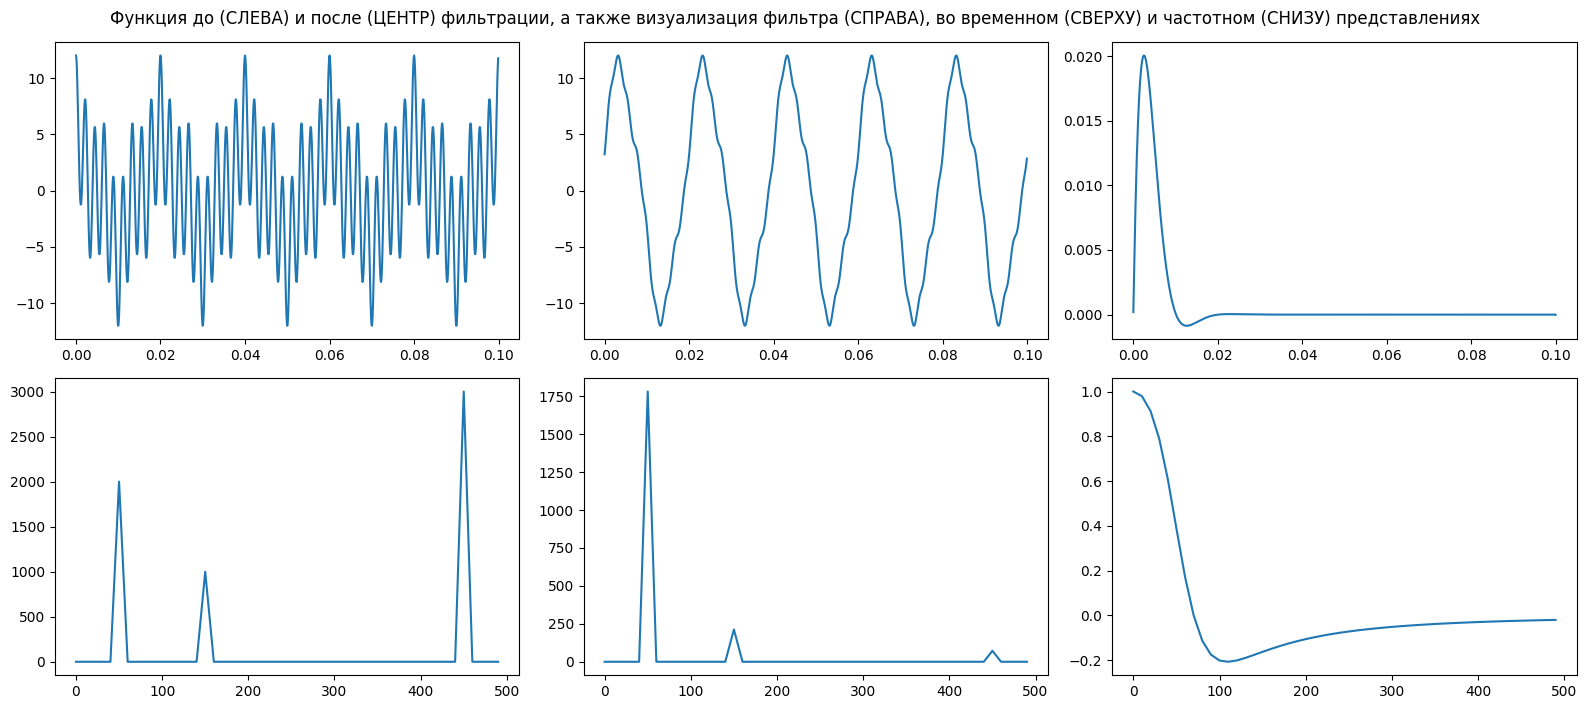

In [54]:
compare_original_filtered(cos_time, cos_frequencies, cos_total1, butterwort_lofreq, 70, 10)

**(3)** Сделать то же самое, но для сигнала косинуса частотами только 50 и 450 Гц…

In [55]:
cos_total2 = np.add(cos_50hz, cos_450hz)
cos_total2_frequencies = np.fft.fftfreq(len(cos_total2), 0.0001)

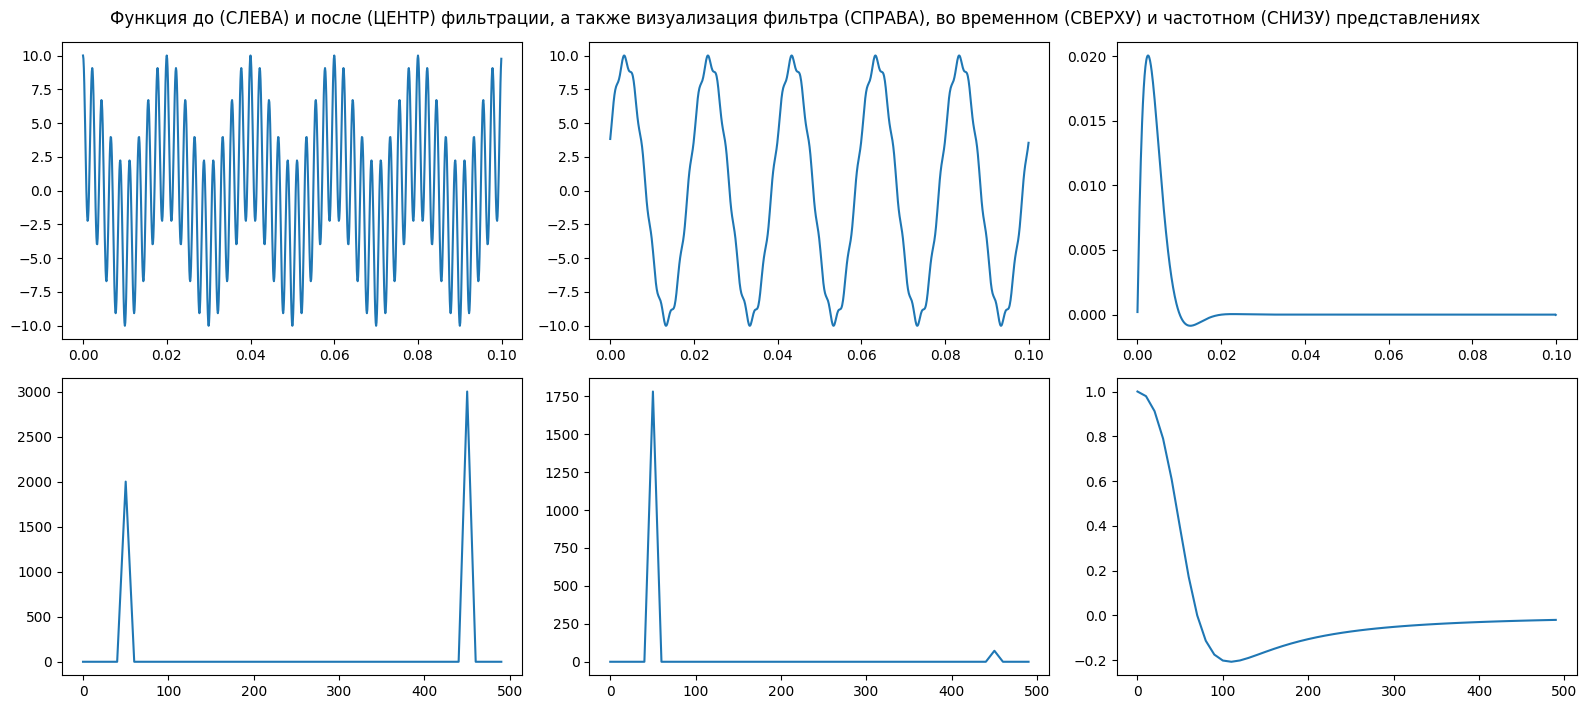

In [56]:
compare_original_filtered(cos_time, cos_total2_frequencies, cos_total2, butterwort_lofreq, 70, 10)

**(4)** Фильтр <!-- Бутер-в-рот-а --> Баттерворта высоких частот (ФВЧ) 2-го порядка (стр. 69-70):

(сравнение по усл.: $\large{ФНЧ = \frac{{W_c}^2}{-W^2+j*\sqrt{2}*W_c*W+\cancel{1}{W_c}^2}, \ ФВЧ = \frac{W^2}{-{W_c}^2+j*\sqrt{2}*W_c*W+\cancel{1}W^2}}$)

In [57]:
def butterwort_hifreq(w, w_c):
    return ((w**2) / (-w_c**2 + (1j * np.sqrt(2) * w_c * w) + w**2))

При применении ФВЧ происходит сильное подавление низких частот (50 и 150), при этом высокие (450 Гц) частоты подавляются гораздо слабее:

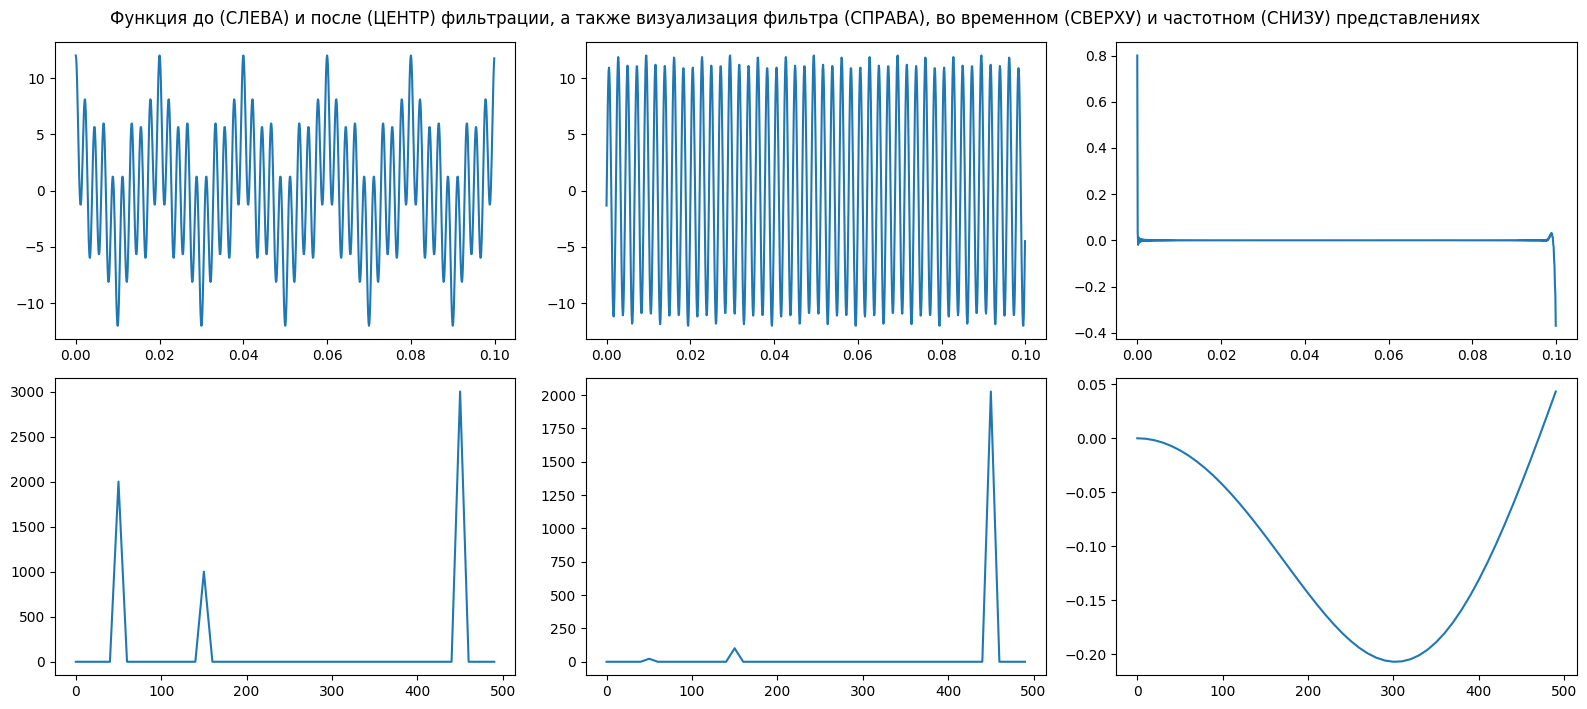

In [58]:
compare_original_filtered(cos_time, cos_frequencies, cos_total1, butterwort_hifreq, 470, 10)

**(5)** Построить полосовой фильтр и заграждающий фильтр (ПФ/ЗФ), настроенный на частоту 150 Гц.

**Полосовой фильтр** — пропускает только частоты В некотором диапазоне (умножаем сигналы, чтобы оставить ненулевым только пересечение)

**Заграждаюзий фильтр** — пропускает только частоты ВНЕ некоторого диапазона (поэлементное сложение "занулит" область пересечения)

In [59]:
# cos_total1_filter_bandpass = cos_total1_filter_hifreq * cos_total1_filter_lofreq
def bandpass(freq, cutoff):
    hifreq_filter = butterwort_hifreq(freq, cutoff)
    lofreq_filter = butterwort_lofreq(freq, cutoff)

    bandpass_filter = hifreq_filter * lofreq_filter

    bandpass_filter /= bandpass_filter.real.min() # НОРМАЛИЗУЕМ ФИЛЬТРЫ ОТ НУЛЯ ДО ЕДИНИЦЫ
    return bandpass_filter

# cos_total1_filter_bandstop = np.array([s_1 + s_2 for s_1, s_2 in zip(cos_total1_filter_hifreq, cos_total1_filter_lofreq)])
# cos_total1_filter_bandstop = np.add(cos_total1_filter_lofreq, cos_total1_filter_hifreq)
def bandstop(freq, cutoff):
    hifreq_filter = butterwort_hifreq(freq, cutoff)
    lofreq_filter = butterwort_lofreq(freq, cutoff)

    bandstop_filter = np.array([s_1 + s_2 for s_1, s_2 in zip(hifreq_filter, lofreq_filter)])

    bandstop_filter /= bandstop_filter.real.max() # НОРМАЛИЗУЕМ ФИЛЬТРЫ ОТ НУЛЯ ДО ЕДИНИЦЫ
    return bandstop_filter

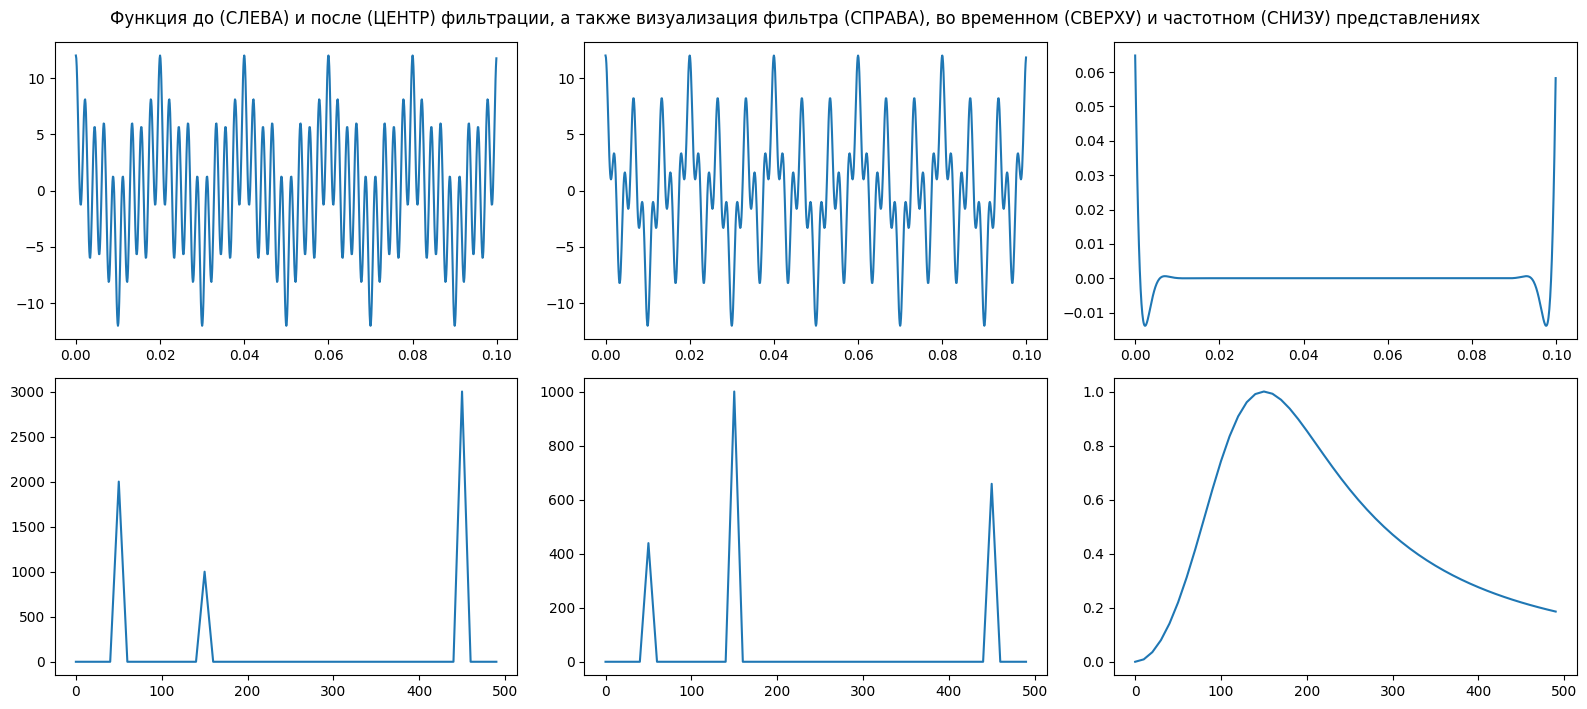

In [60]:
compare_original_filtered(cos_time, cos_frequencies, cos_total1, bandpass, 150, 10)

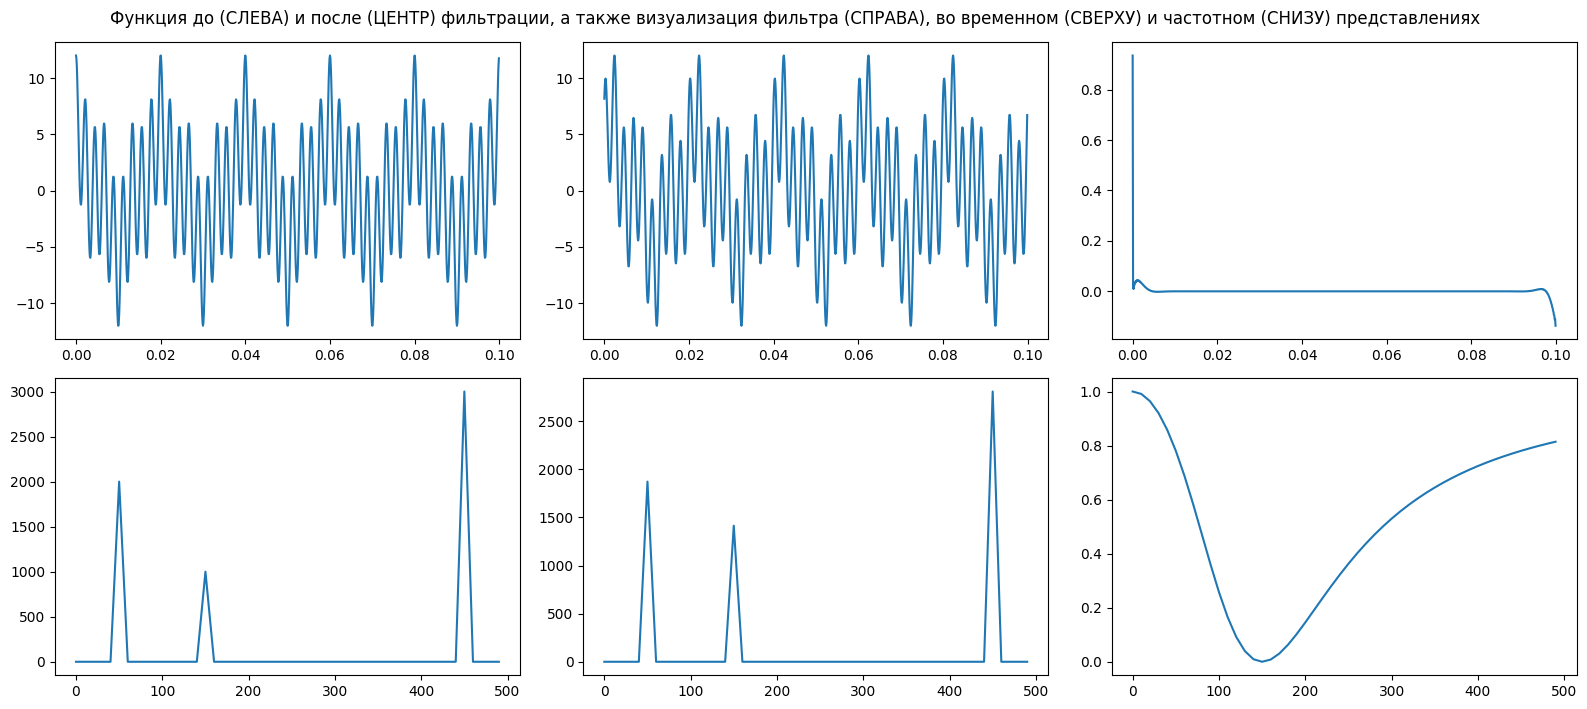

In [61]:
compare_original_filtered(cos_time, cos_frequencies, cos_total1, bandstop, 150, 10)

**(6)** Фильтр Баттерворта произвольного порядка с автоматическим определением полюсов фильтра:

(при порядке **фильтра** $n \to \infin$ амплитутдно-частотная хар-ка **фильтра** приближается к идеальной, т.е. он становится всё менее "плавным")

In [62]:
def butterwort_lofreq_nth(n, w, w_c):
    imag = (w / w_c)
    real = (0 / w_c) # Не самое элегантное решение, но в методичке ответа, как найти кофецент
                     # реальной части a, попросту нет, а в Интернетах написано, что ДЧ можно
                     # отбросить, если у сигнала нет затухающих колебаний ("damping coefficient").
    S = real + 1j * imag
    
    return (1 / (1 + (-1)**n * (S)**(2*n)))

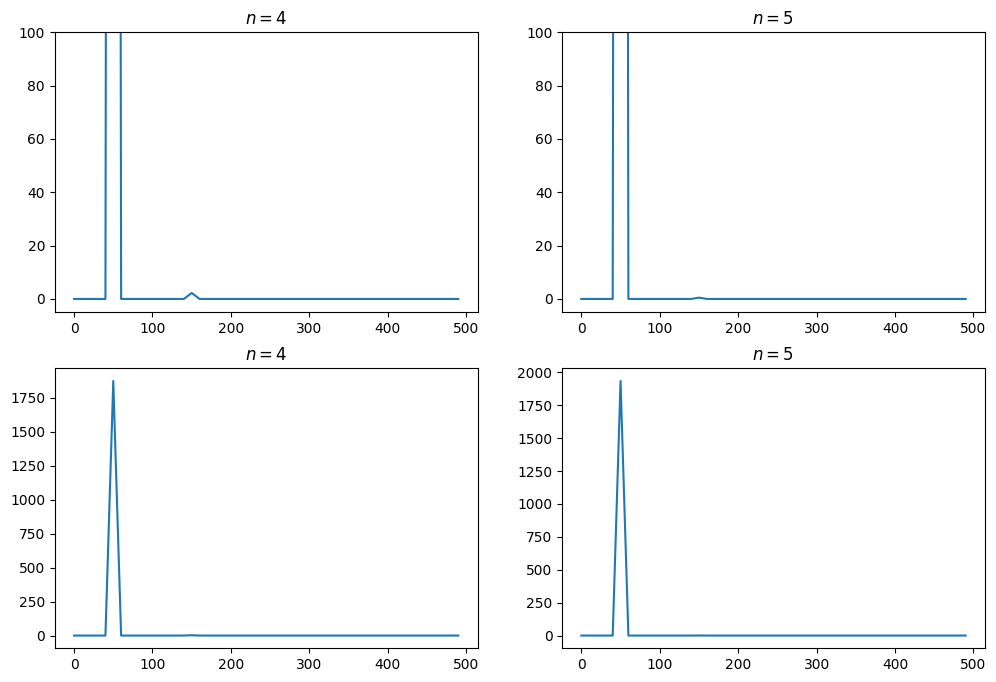

In [63]:
cos_total1_filter_lofreq4 = butterwort_lofreq_nth(4, cos_frequencies, 70)
cos_total1_filter_lofreq5 = butterwort_lofreq_nth(5, cos_frequencies, 70)
cos_total1_filter_lofreq1 = butterwort_lofreq_nth(1, cos_frequencies, 70)

cos_total1_filtered_lofreq4_fft = np.multiply(cos_total1_fft, np.abs(cos_total1_filter_lofreq4))
cos_total1_filtered_lofreq5_fft = np.multiply(cos_total1_fft, np.abs(cos_total1_filter_lofreq5))
cos_total1_filtered_lofreq1_fft = np.multiply(cos_total1_fft, np.abs(cos_total1_filter_lofreq1))


plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title('$n = 4$')
plt.plot(
    cos_frequencies[0:len(cos_frequencies)//20],
    np.abs(cos_total1_filtered_lofreq4_fft[0:len(cos_frequencies)//20])
)
plt.ylim(-5, 100)

plt.subplot(2, 2, 2)
plt.title('$n = 5$')
plt.plot(
    cos_frequencies[0:len(cos_frequencies)//20],
    np.abs(cos_total1_filtered_lofreq5_fft[0:len(cos_frequencies)//20])
)
plt.ylim(-5, 100)

plt.subplot(2, 2, 3)
plt.title('$n = 4$')
plt.plot(
    cos_frequencies[0:len(cos_frequencies)//20],
    np.abs(cos_total1_filtered_lofreq4_fft[0:len(cos_frequencies)//20])
)

plt.subplot(2, 2, 4)
plt.title('$n = 5$')
plt.plot(
    cos_frequencies[0:len(cos_frequencies)//20],
    np.abs(cos_total1_filtered_lofreq5_fft[0:len(cos_frequencies)//20])
)

# plt.subplot(2, 2, 3)
# plt.title('$n = 1$')
# plt.plot(
#     cos_frequencies[0:len(cos_frequencies)//20],
#     np.abs(cos_total1_filtered_lofreq1_fft[0:len(cos_frequencies)//20])
# )
# plt.ylim(-10, 200)

# plt.subplot(2, 2, 4)
# plt.title('Оригинал')
# plt.plot(
#     cos_frequencies[0:len(cos_frequencies)//20],
#     np.abs(cos_total1_filtered_lofreq_orig_fft[0:len(cos_frequencies)//20])
# )
# plt.ylim(-10, 200)

plt.show()

("нужные" частоты также становятся слабее, но несравнимо меньше, чем фильтруемые)

<br>

**(7) (8)** Сравним алгоритм ФНЧ 5-го порядка с изначальной реализацией ФНЧ, а также с его реализацией в `scipy.signal`:

<!-- https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter -->
https://dsp.stackexchange.com/questions/49460/apply-low-pass-butterworth-filter-in-python

In [64]:
cos_time_disc = (1 / 0.0001) # Частота дискр-ии = 1 / Врем.шаг из cos_time
cutoff_norm = 70 / (cos_time_disc / 2)
print(cutoff_norm)

nom, denom = butter(5, cutoff_norm, btype='low', analog=False)

cos_total1_filtered_scipy = lfilter(nom, denom, cos_total1)

cos_total1_filtered_scipy_fft = np.fft.fft(cos_total1_filtered_scipy)


# plt.plot(cos_time, cos_total1_filtered_scipy)
# plt.plot(cos_time, cos_total1)

# plt.show()


cos_total1_filtered_lofreq_fft = np.multiply(cos_total1_fft, np.abs(cos_total1_filter_lofreq))

0.014


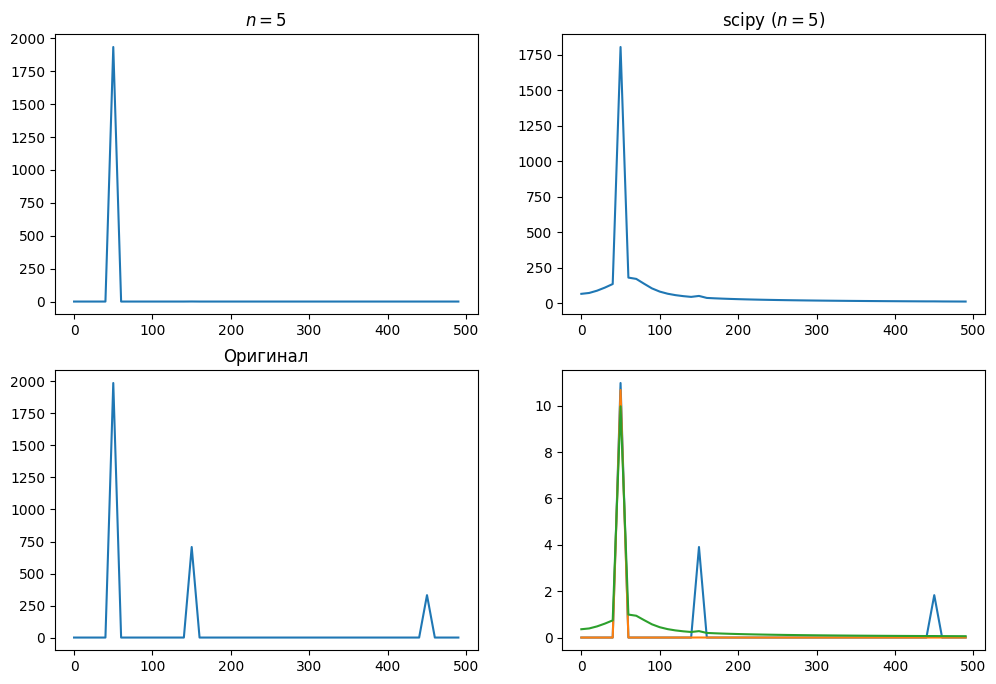

In [65]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title('$n = 5$')
plt.plot(
    cos_frequencies[0:len(cos_frequencies)//20],
    np.abs(cos_total1_filtered_lofreq5_fft[0:len(cos_frequencies)//20])
)
# plt.ylim(-10, 200)

plt.subplot(2, 2, 2)
plt.title('scipy ($n = 5$)')
plt.plot(
    cos_frequencies[0:len(cos_frequencies)//20],
    np.abs(cos_total1_filtered_scipy_fft[0:len(cos_frequencies)//20])
)
# plt.ylim(-10, 200)

plt.subplot(2, 2, 3)
plt.title('Оригинал')
plt.plot(
    cos_frequencies[0:len(cos_frequencies)//20],
    np.abs(cos_total1_filtered_lofreq_fft[0:len(cos_frequencies)//20])
)
# plt.ylim(-10, 200)

plt.subplot(2, 2, 4)
plt.plot(
    cos_frequencies[0:len(cos_frequencies)//20],
    np.abs(cos_total1_filtered_lofreq_fft[0:len(cos_frequencies)//20]) / cos_total1_filtered_scipy_fft.max()
)
plt.plot(
    cos_frequencies[0:len(cos_frequencies)//20],
    np.abs(cos_total1_filtered_lofreq5_fft[0:len(cos_frequencies)//20]) / cos_total1_filtered_scipy_fft.max()
)
plt.plot(
    cos_frequencies[0:len(cos_frequencies)//20],
    np.abs(cos_total1_filtered_scipy_fft[0:len(cos_frequencies)//20]) / cos_total1_filtered_scipy_fft.max()
)
# plt.ylim(-10, 200)

plt.show()

**(9)** Фильтры частот особенно полезны для устранения шумов из зашумлённых сигналов:

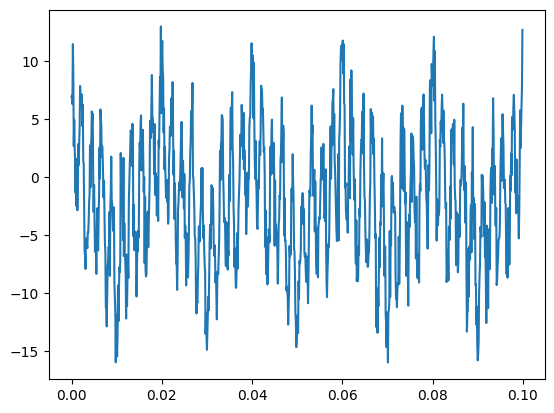

In [66]:
cos_noisy = cos_total1 + np.random.normal(-2, 2, cos_time.shape)

plt.plot(cos_time, cos_noisy)
plt.show()

In [67]:
cos_noisy_fft = np.fft.fft(cos_noisy)

cos_noisy_filter_lofreq100 = butterwort_lofreq_nth(100, cos_frequencies, 470)
cos_noisy_filter_lofreq5 = butterwort_lofreq_nth(5, cos_frequencies, 470)
cos_noisy_filter_lofreq = butterwort_lofreq(cos_frequencies, 470)

cos_noisy_filtered_lofreq100_fft = np.multiply(cos_noisy_fft, cos_noisy_filter_lofreq100)
cos_noisy_filtered_lofreq5_fft = np.multiply(cos_noisy_fft, cos_noisy_filter_lofreq5)
cos_noisy_filtered_lofreq_fft = np.multiply(cos_noisy_fft, cos_noisy_filter_lofreq)

cos_noisy_filtered_lofreq100 = np.fft.ifft(cos_noisy_filtered_lofreq100_fft)
cos_noisy_filtered_lofreq5 = np.fft.ifft(cos_noisy_filtered_lofreq5_fft)
cos_noisy_filtered_lofreq = np.fft.ifft(cos_noisy_filtered_lofreq_fft)

cos_noisy_filtered_lofreq100_err = np.subtract(np.array(cos_noisy_filtered_lofreq100), np.array(cos_total1))
cos_noisy_filtered_lofreq5_err = np.subtract(np.array(cos_noisy_filtered_lofreq5), np.array(cos_total1))
cos_noisy_filtered_lofreq_err = np.subtract(np.array(cos_noisy_filtered_lofreq), np.array(cos_total1))

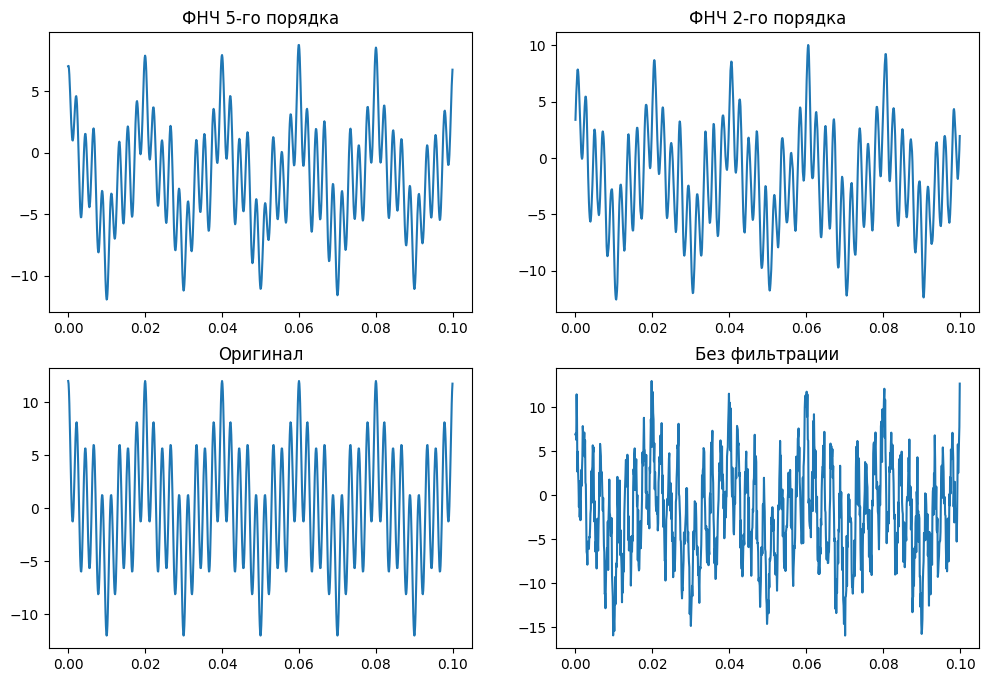

In [68]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title('ФНЧ 5-го порядка')
# plt.plot(cos_time, cos_noisy_filtered_lofreq100)
plt.plot(cos_time, cos_noisy_filtered_lofreq5)

plt.subplot(2, 2, 2)
plt.title('ФНЧ 2-го порядка')
plt.plot(cos_time, cos_noisy_filtered_lofreq)

plt.subplot(2, 2, 3)
plt.title('Оригинал')
plt.plot(cos_time, cos_total1)

plt.subplot(2, 2, 4)
plt.title('Без фильтрации')
plt.plot(cos_time, cos_noisy)

plt.show()

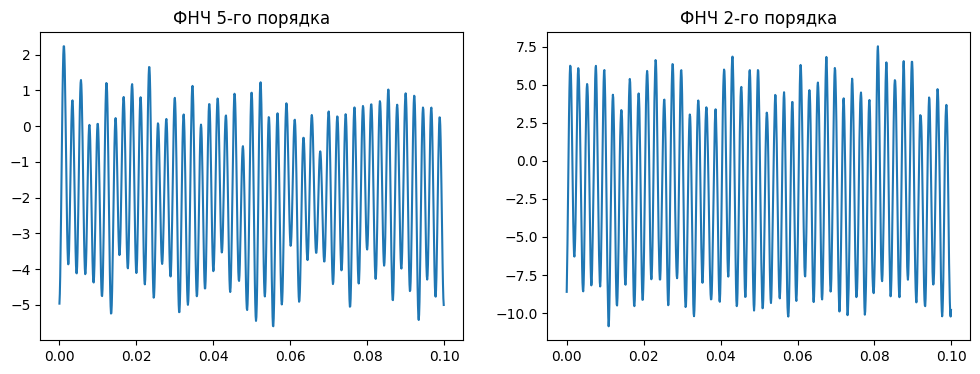

In [69]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('ФНЧ 5-го порядка')
# plt.plot(cos_time, cos_noisy_filtered_lofreq100_err)
plt.plot(cos_time, cos_noisy_filtered_lofreq5_err)

plt.subplot(1, 2, 2)
plt.title('ФНЧ 2-го порядка')
plt.plot(cos_time, cos_noisy_filtered_lofreq_err)

plt.show()

**(10★) Реализовать [ФНЧ Чебышева I типа](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D0%BB%D1%8C%D1%82%D1%80_%D0%A7%D0%B5%D0%B1%D1%8B%D1%88%D1%91%D0%B2%D0%B0#/media/%D0%A4%D0%B0%D0%B9%D0%BB:Filters_order5-ru.svg).**

*~~Задание со звёздочой. Ну а я человек простой, до звёзд достать не мечтаю :)~~*

*[А тысячу лет назад, мне звёзды казались так близко!…](https://www.youtube.com/watch?v=G7uQteSWT5k)*

В методичке не нашёл, но на Википедии всё расписано на удивление понятно: https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D0%BB%D1%8C%D1%82%D1%80_%D0%A7%D0%B5%D0%B1%D1%8B%D1%88%D1%91%D0%B2%D0%B0#%D0%A4%D0%B8%D0%BB%D1%8C%D1%82%D1%80_%D0%A7%D0%B5%D0%B1%D1%8B%D1%88%D1%91%D0%B2%D0%B0_I_%D1%80%D0%BE%D0%B4%D0%B0

И вот ещё (нас интересует Фильтр Чебышева типа Т, он же пропускной): http://www.mai-trt.ru/docs/edu/lek_or_ruch_07.pdf

In [70]:
def cheb_polynom_T(n, x):
    if n <= 1:
        return x**n # Будет 1 при n=0, либо x при n=1
    else:
        return 2*x * cheb_polynom_T(n-1, x) - cheb_polynom_T(n-2, x)

Полином Чебышёва $T$ (выше), лежащий в основе этого фильтра: $T_{n+1}(w) = 2x*T_{n}(w) - T_{n-1}(w)$

Собственно, сам фильтр: $K(w) = \large{\frac{1}{\sqrt{1 + \epsilon^2 * T(n, \frac{w}{w_с})^2}}}$

- `n` — порядок ($n = 0,1,2,3...$)
- `w` — частота
- `w_c` — частота среза
- `epsilon` — показатель пульсации (усиление/ослабление колебаний; нет эффекта при $\epsilon=1$)

In [ ]:
def cheb_filter_T(n, w, w_c, epsilon):
    T = cheb_polynom_T(n, (w/w_c))
    return (1 / np.sqrt(1 + epsilon**2 * T**2))

In [72]:
# cos_total1_fft = np.fft.fft(cos_total1)

# plt.subplot(2, 3, 2)
# cos_total1_filter_chebT = [cheb_filter_T(1, w, 100, 1) for w in cos_frequencies]
# cos_total1_filtered_chebT_fft = np.multiply(cos_total1_fft, cos_total1_filter_chebT)

# plt.title('$n = 1, w_c = 100, \\epsilon = 1$')
# plt.plot(cos_time, np.fft.ifft(cos_total1_filtered_chebT_fft))

# plt.subplot(2, 3, 5)

# plt.show()

Порядок n = 1; Частота среза w_c = 150; Показатель пульсации epsilon = 1


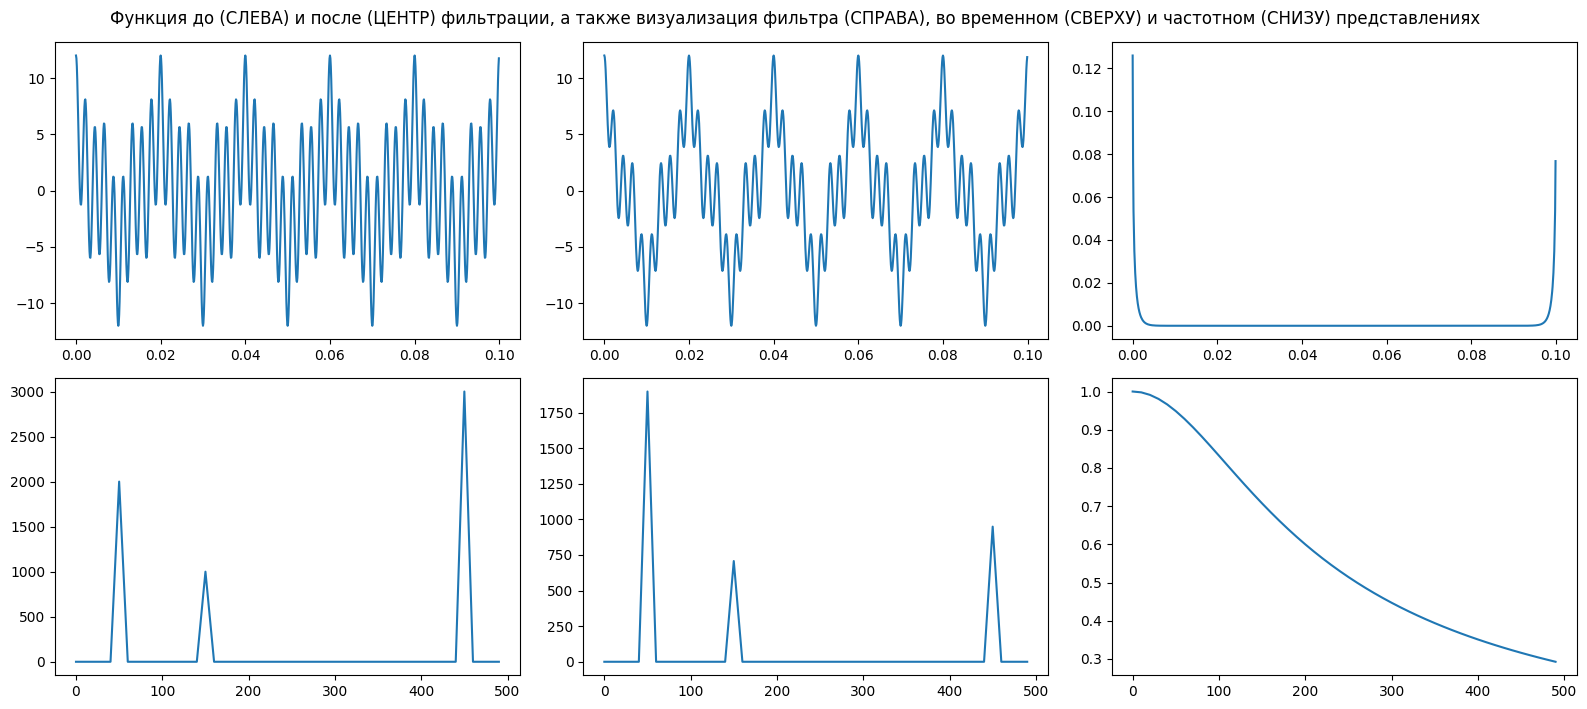

Порядок n = 3; Частота среза w_c = 150; Показатель пульсации epsilon = 1


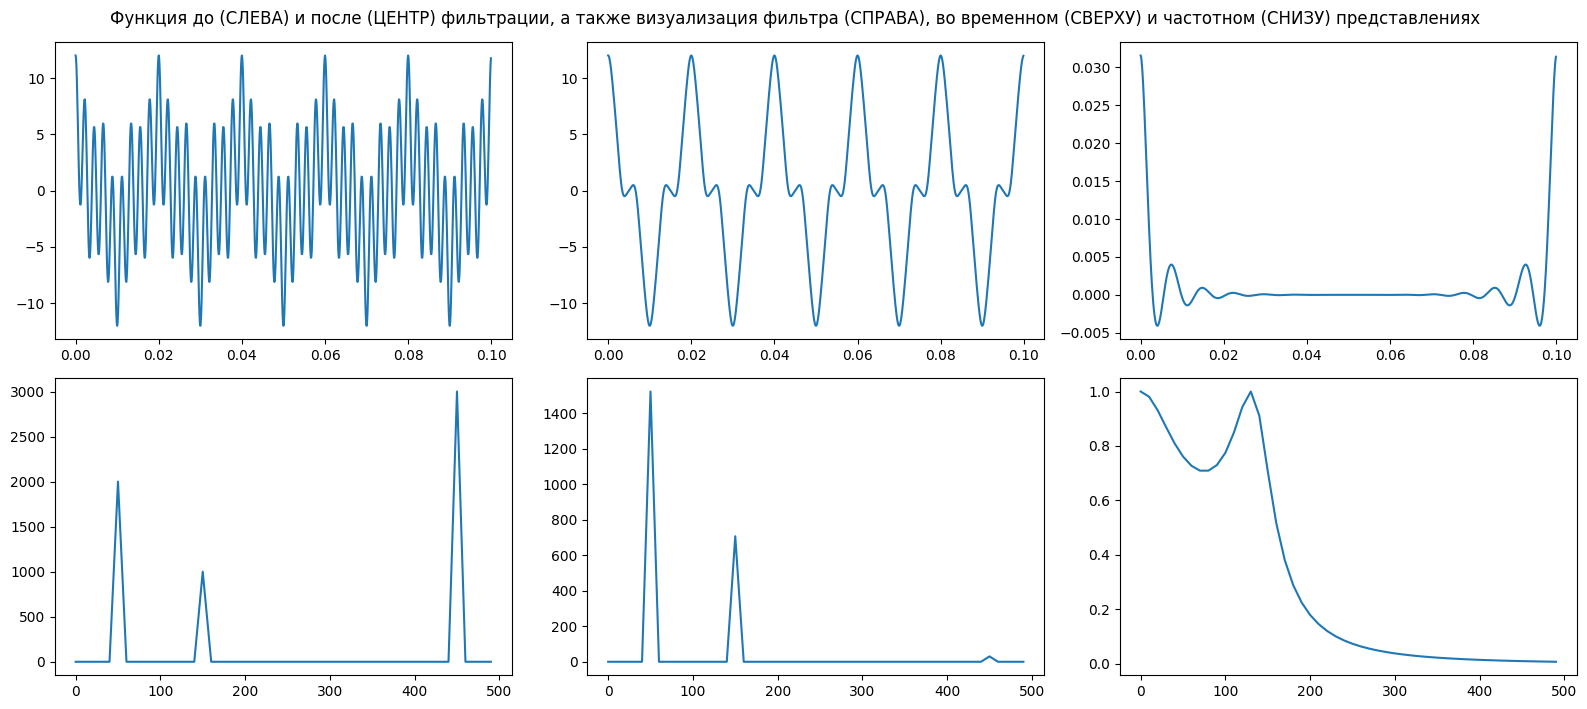

Порядок n = 10; Частота среза w_c = 150; Показатель пульсации epsilon = 1


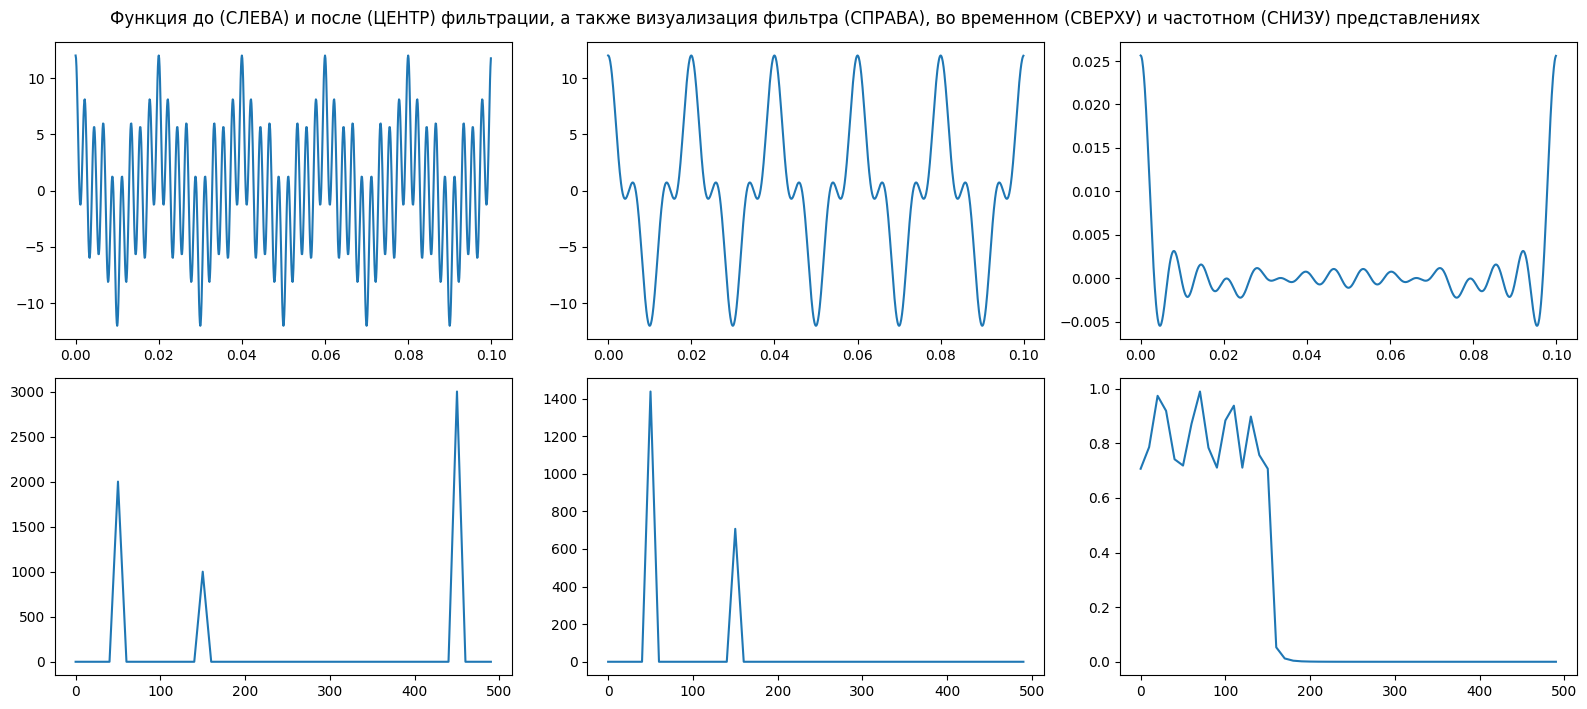

In [109]:
print('Порядок n = 1; Частота среза w_c = 150; Показатель пульсации epsilon = 1')
compare_original_filtered(cos_time, cos_frequencies, cos_total1, (lambda w, w_c: cheb_filter_T(1, w, w_c, 1)), 150, 10)

print('Порядок n = 3; Частота среза w_c = 150; Показатель пульсации epsilon = 1')
compare_original_filtered(cos_time, cos_frequencies, cos_total1, (lambda w, w_c: cheb_filter_T(3, w, w_c, 1)), 150, 10)

print('Порядок n = 10; Частота среза w_c = 150; Показатель пульсации epsilon = 1')
compare_original_filtered(cos_time, cos_frequencies, cos_total1, (lambda w, w_c: cheb_filter_T(10, w, w_c, 1)), 150, 10)

Порядок n = 5; Частота среза w_c = 50; Показатель пульсации epsilon = 1


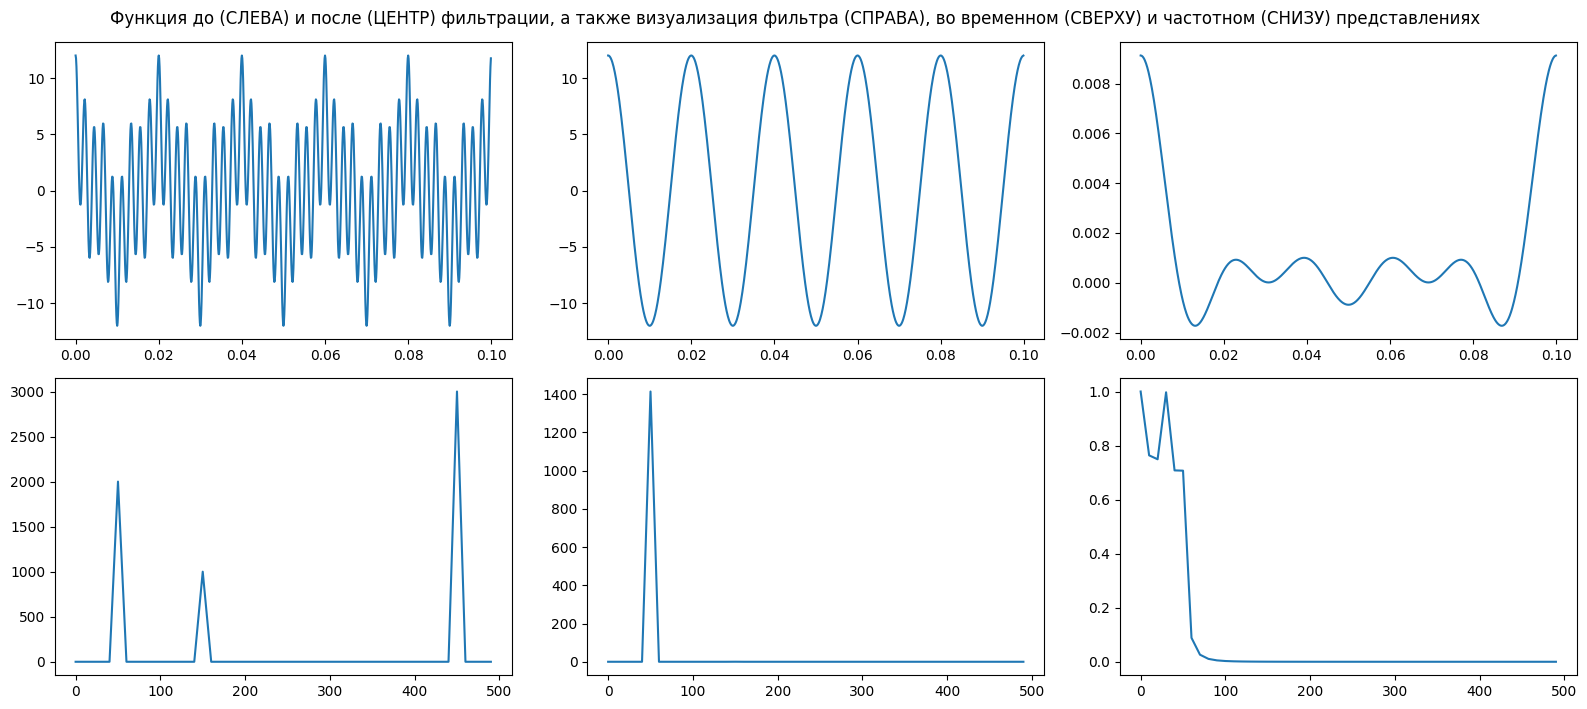

Порядок n = 5; Частота среза w_c = 150; Показатель пульсации epsilon = 1


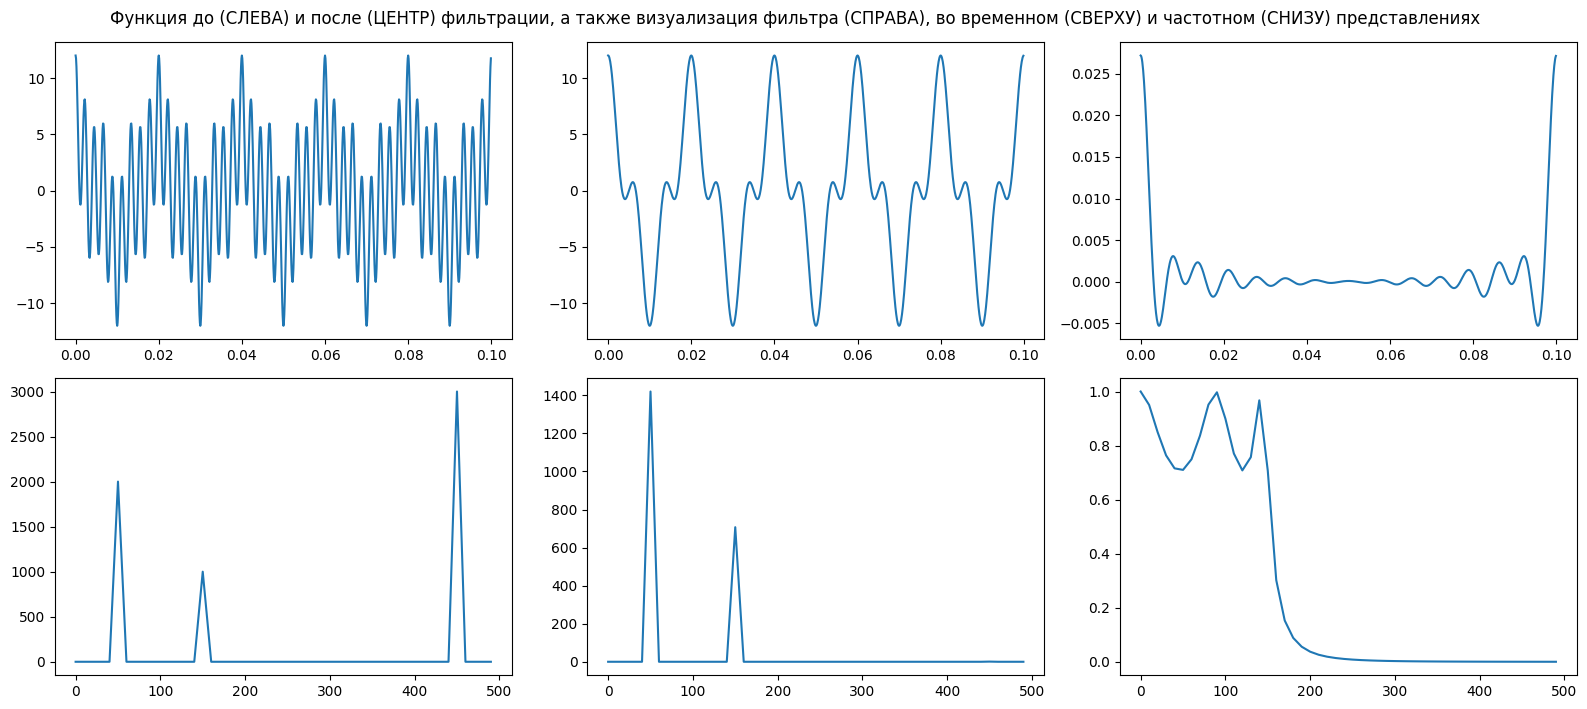

Порядок n = 5; Частота среза w_c = 400; Показатель пульсации epsilon = 1


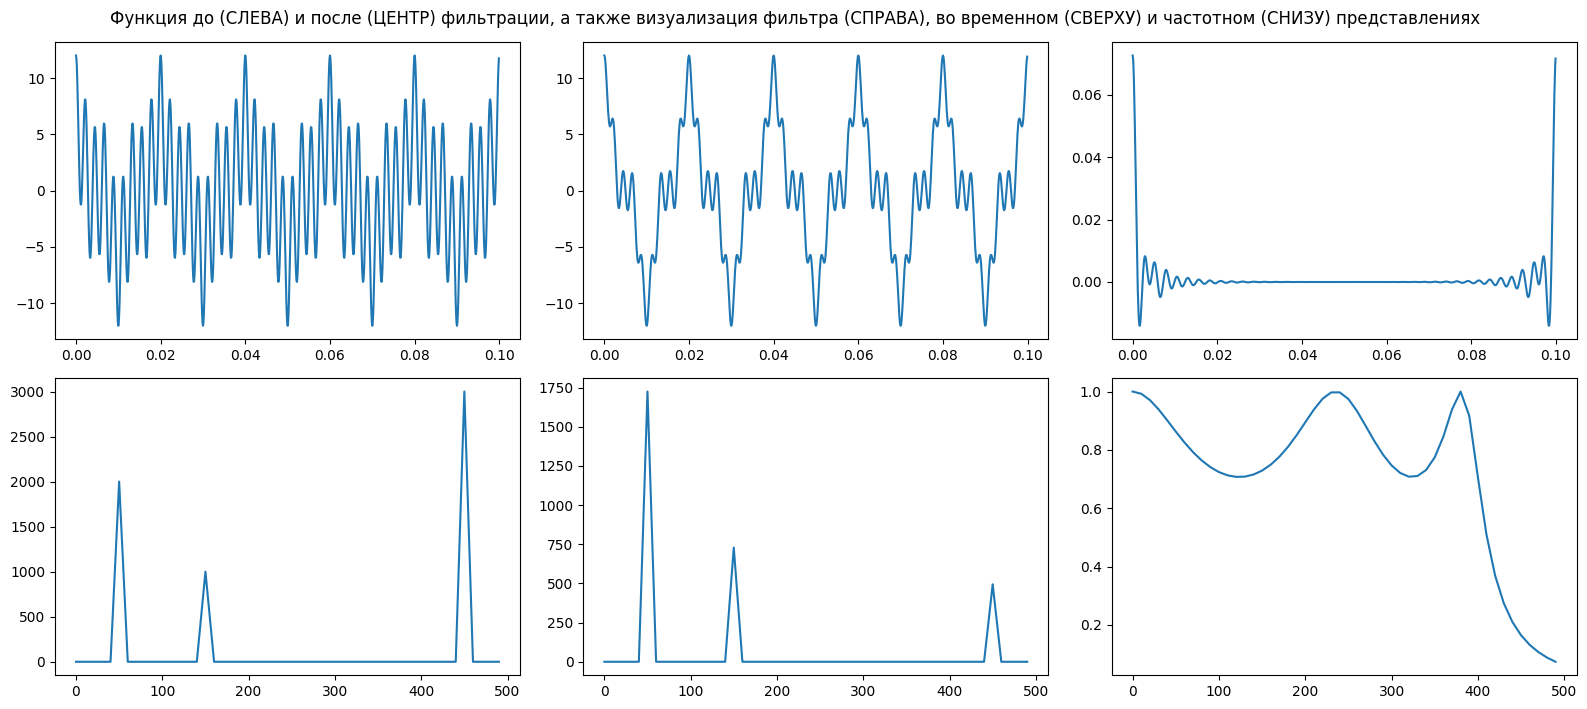

Порядок n = 10; Частота среза w_c = 400; Показатель пульсации epsilon = 1


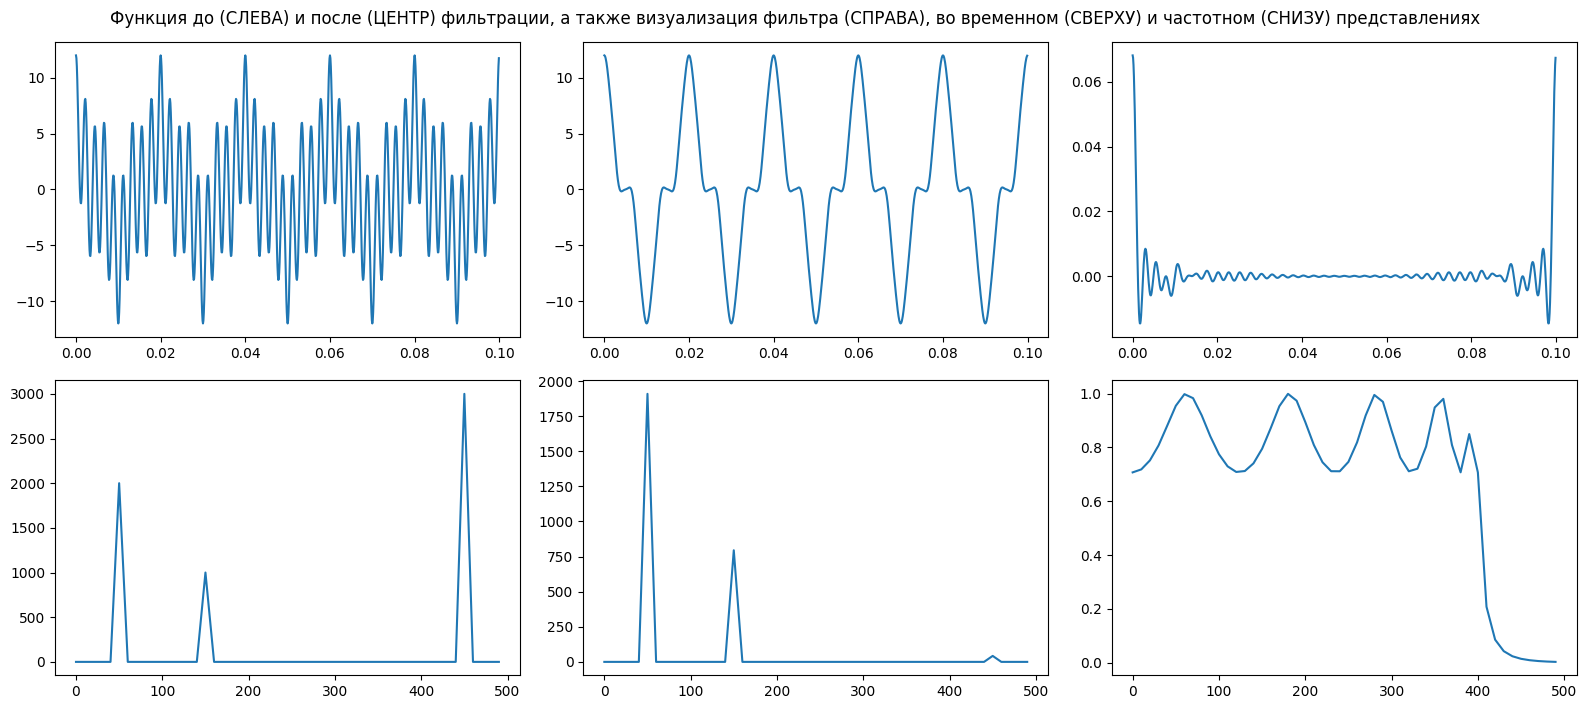

In [117]:
print('Порядок n = 5; Частота среза w_c = 50; Показатель пульсации epsilon = 1')
compare_original_filtered(cos_time, cos_frequencies, cos_total1, (lambda w, w_c: cheb_filter_T(5, w, w_c, 1)), 50, 10)

print('Порядок n = 5; Частота среза w_c = 150; Показатель пульсации epsilon = 1')
compare_original_filtered(cos_time, cos_frequencies, cos_total1, (lambda w, w_c: cheb_filter_T(5, w, w_c, 1)), 150, 10)

print('Порядок n = 5; Частота среза w_c = 400; Показатель пульсации epsilon = 1')
compare_original_filtered(cos_time, cos_frequencies, cos_total1, (lambda w, w_c: cheb_filter_T(5, w, w_c, 1)), 400, 10)

print('Порядок n = 10; Частота среза w_c = 400; Показатель пульсации epsilon = 1')
compare_original_filtered(cos_time, cos_frequencies, cos_total1, (lambda w, w_c: cheb_filter_T(10, w, w_c, 1)), 400, 10)

Порядок n = 5; Частота среза w_c = 450; Показатель пульсации epsilon = 0.2


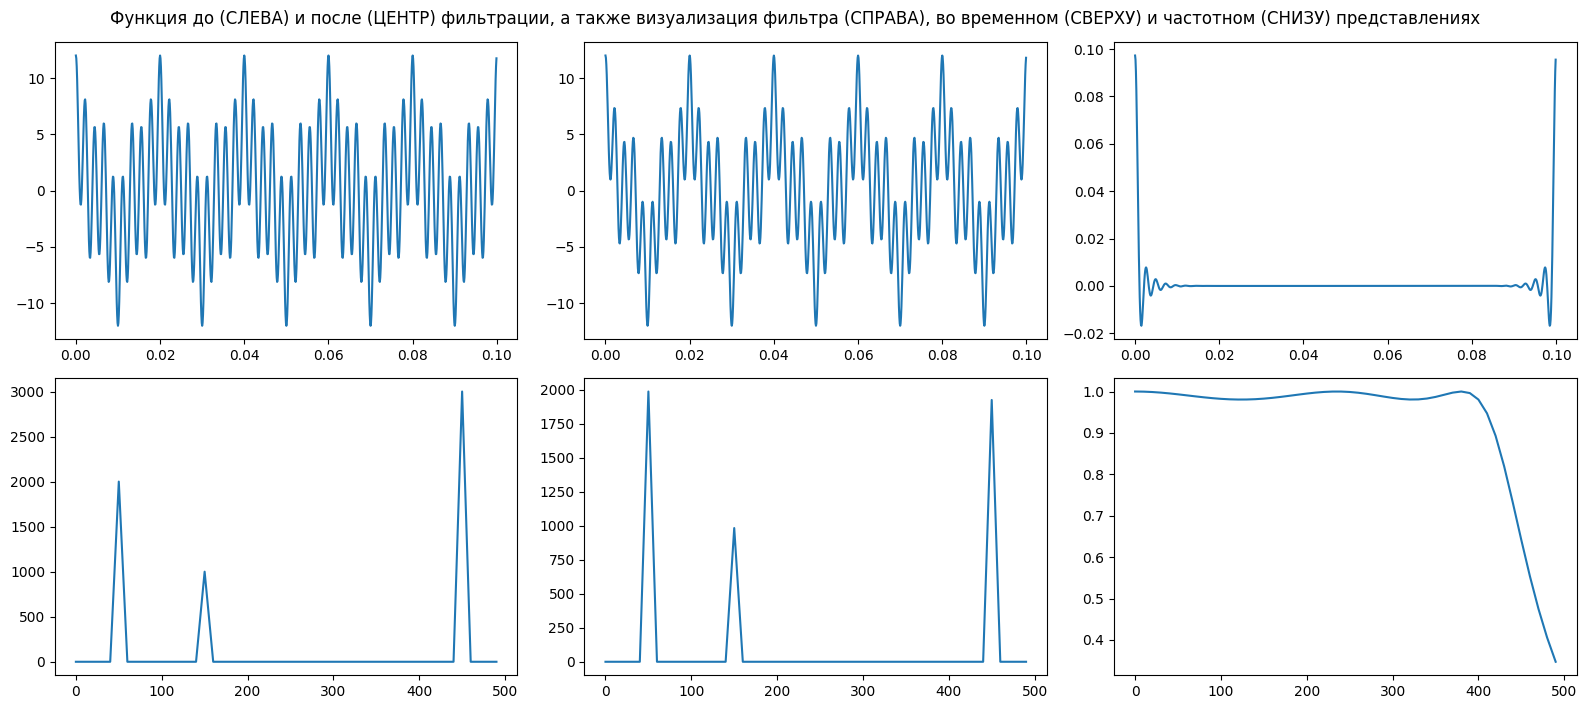

Порядок n = 5; Частота среза w_c = 450; Показатель пульсации epsilon = 0.6


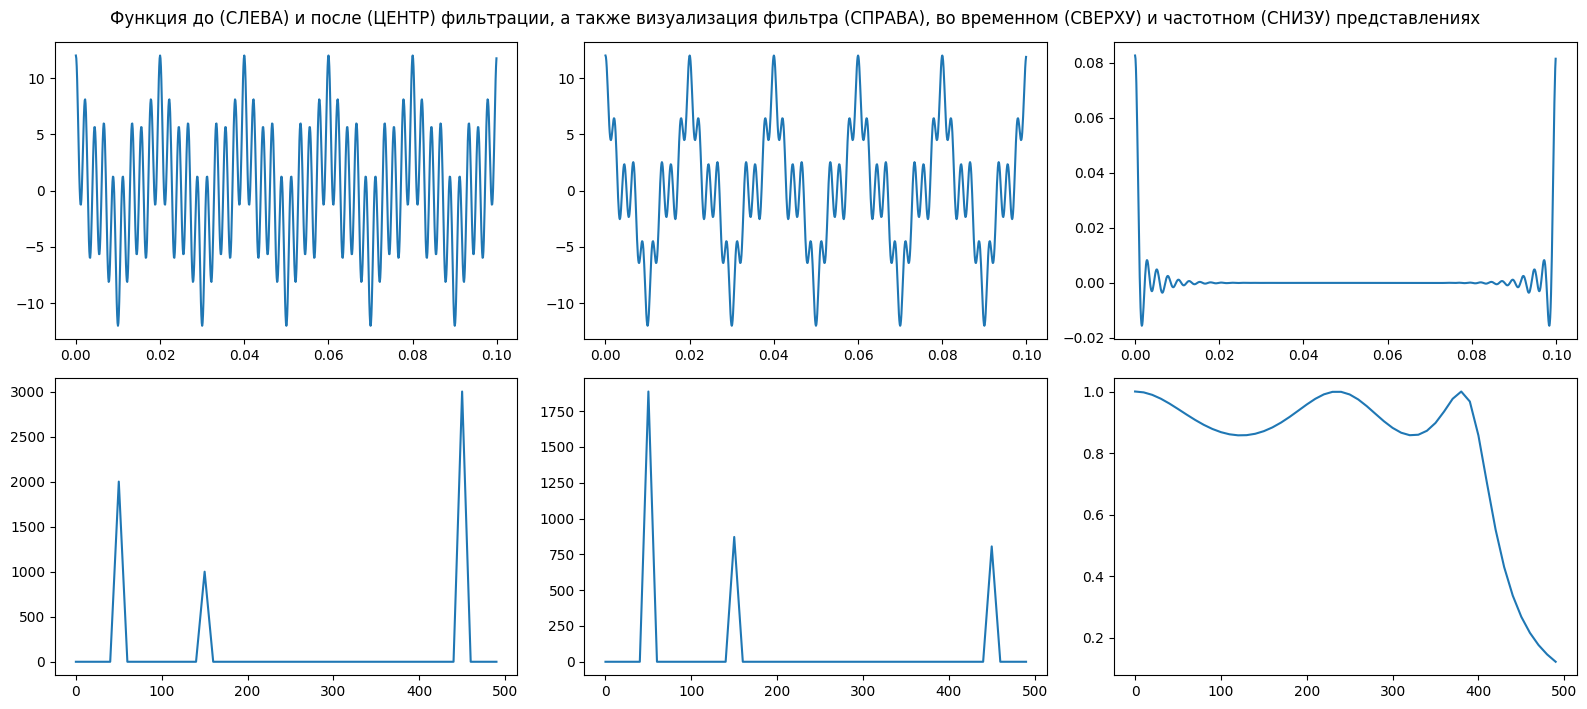

Порядок n = 5; Частота среза w_c = 450; Показатель пульсации epsilon = 1


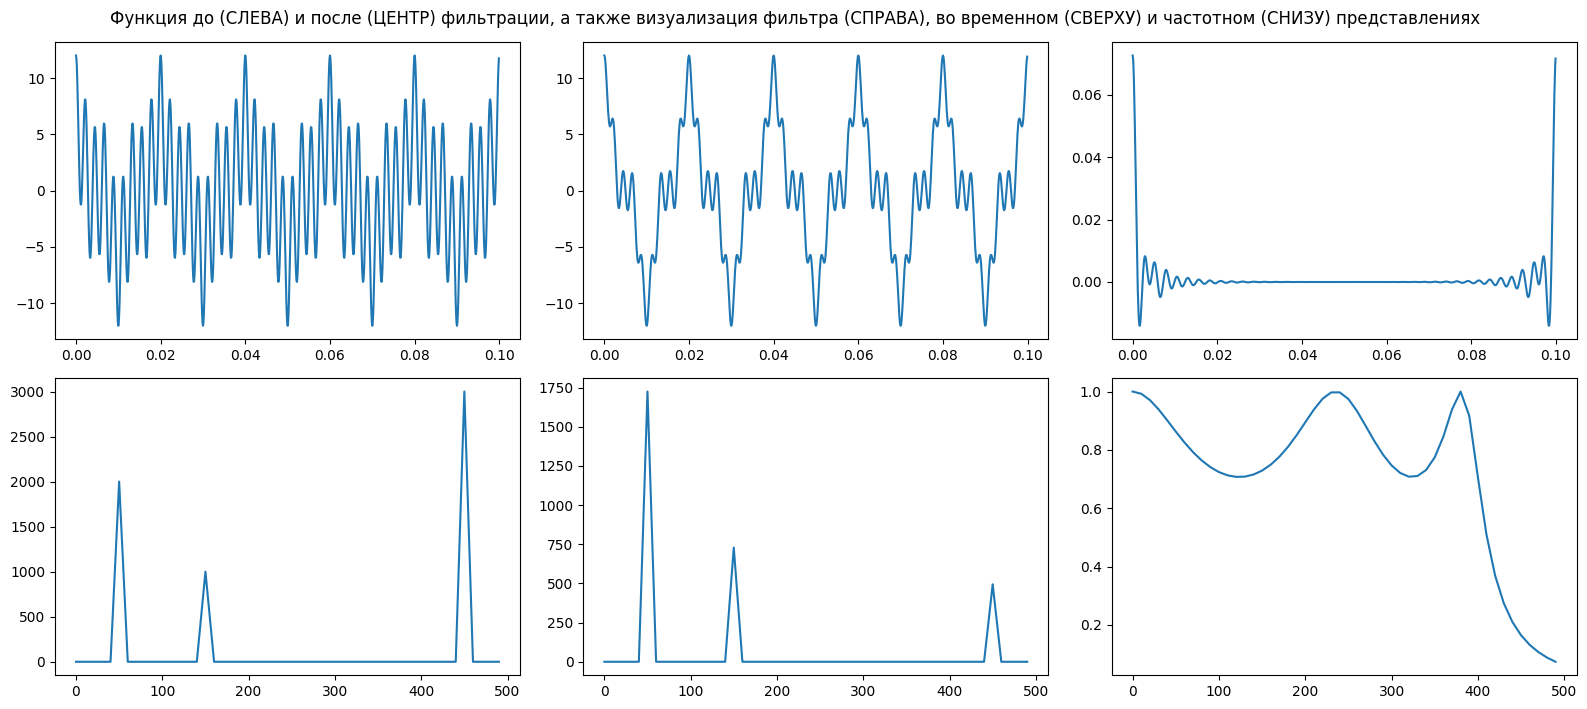

Порядок n = 5; Частота среза w_c = 450; Показатель пульсации epsilon = 10


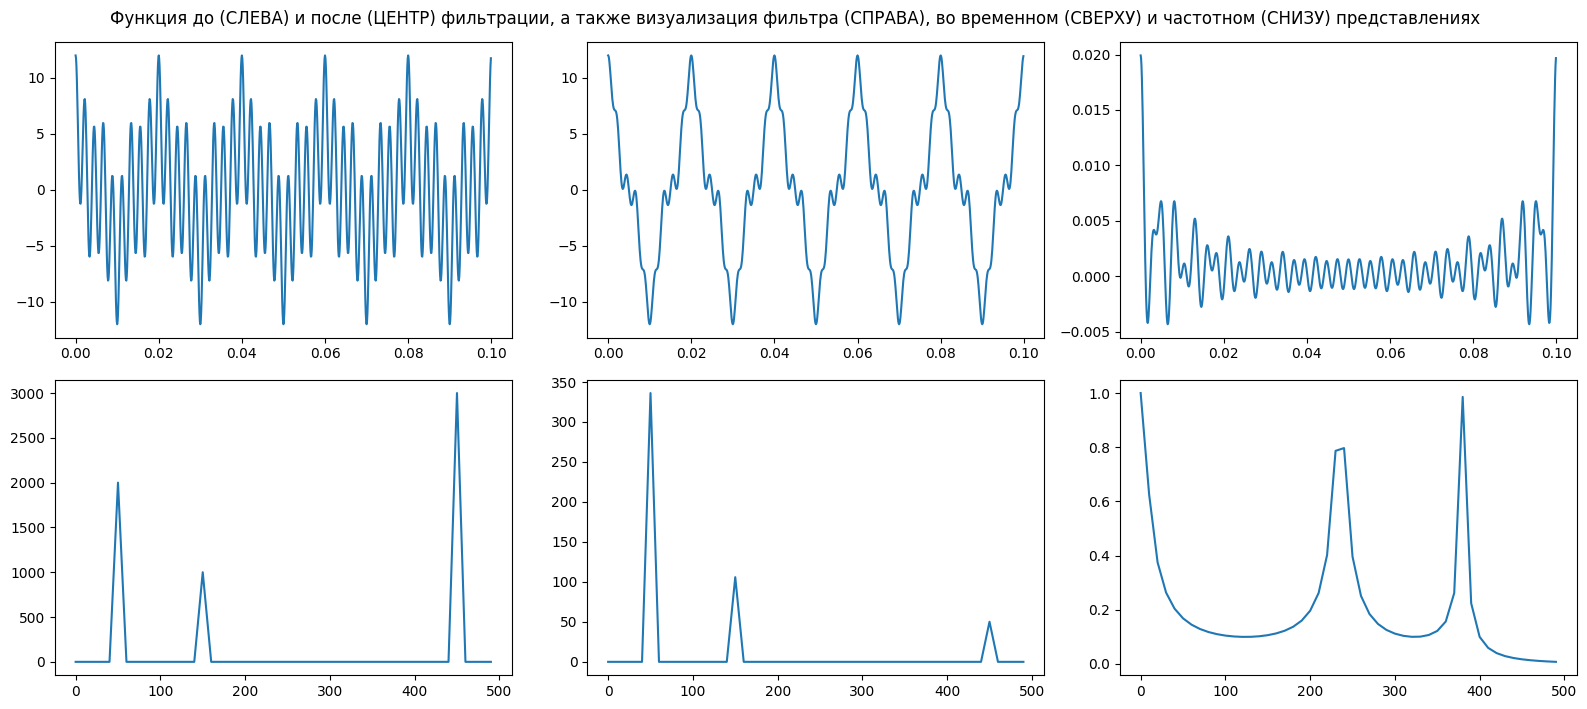

Порядок n = 5; Частота среза w_c = 450; Показатель пульсации epsilon = 100


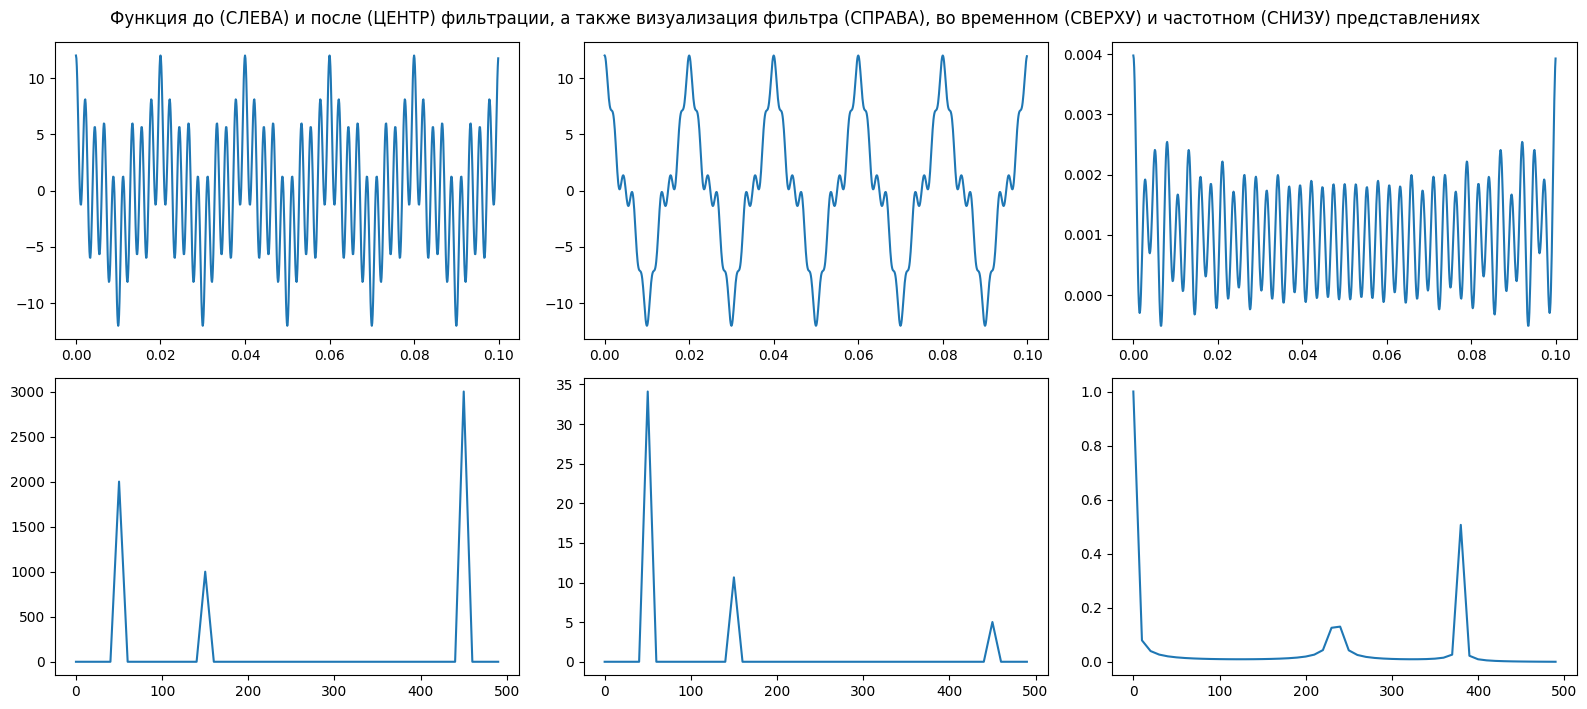

In [124]:
print('Порядок n = 5; Частота среза w_c = 450; Показатель пульсации epsilon = 0.2')
compare_original_filtered(cos_time, cos_frequencies, cos_total1, (lambda w, w_c: cheb_filter_T(5, w, w_c, 0.2)), 400, 10)

print('Порядок n = 5; Частота среза w_c = 450; Показатель пульсации epsilon = 0.6')
compare_original_filtered(cos_time, cos_frequencies, cos_total1, (lambda w, w_c: cheb_filter_T(5, w, w_c, 0.6)), 400, 10)

print('Порядок n = 5; Частота среза w_c = 450; Показатель пульсации epsilon = 1')
compare_original_filtered(cos_time, cos_frequencies, cos_total1, (lambda w, w_c: cheb_filter_T(5, w, w_c, 1)), 400, 10)

print('Порядок n = 5; Частота среза w_c = 450; Показатель пульсации epsilon = 10')
compare_original_filtered(cos_time, cos_frequencies, cos_total1, (lambda w, w_c: cheb_filter_T(5, w, w_c, 10)), 400, 10)

print('Порядок n = 5; Частота среза w_c = 450; Показатель пульсации epsilon = 100')
compare_original_filtered(cos_time, cos_frequencies, cos_total1, (lambda w, w_c: cheb_filter_T(5, w, w_c, 100)), 400, 10)

*4:40 ночи, ёмаё... Сегодня кстати день зимнего солнцестояния, вооооооот*